In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
shutil.unpack_archive('/content/drive/MyDrive/AML/ieee-fraud-detection.zip', '/content/drive/MyDrive/AML/task1')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from numpy.linalg import eigh

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loss functions

In [ ]:
def n_loss(shape, loss):
    def new_loss(msk, y_pred):
        X_values = msk[:, :shape]
        nan_msk = msk[:, shape:]
        om = 1 - nan_msk
        x = X_values * om
        x_hat = y_pred * om
        return loss(x, x_hat)

    return new_loss

In [ ]:
def r_loss(X, y_pred, new_loss, model, l):
    n_l = new_loss(X, y_pred)
    loss = 0
    vals = X
    network_l = list(model.children())
    for i in range(len(network_l)):
        vals = F.relu((network_l[i](vals)))
        loss += torch.mean(torch.abs(vals))
    return l * loss + n_l


#Trainer

In [ ]:
class AETrainer:
    def __init__(self,device,train_data_loader,test_data_loader, data_shape, model, regularization=False,vae=False):
        self.device = device
        self.train_data_loader=train_data_loader
        self.test_data_loader=test_data_loader
        self.data_shape = data_shape
        if not vae:
          self.model = model(self.data_shape * 2,12).to(self.device)
        else:
          self.model = model(self.data_shape * 2).to(self.device)
        self.regularization = regularization
        self.vae=vae

    def _train_epoch(self, model, optimizer, loss_n):
        epoch_loss = 0
        model.train()

        for batch in self.train_data_loader:
            input_ = batch
            input_ = input_.to(self.device)
            optimizer.zero_grad()
            pred = model(input_)
            if not self.vae:
              if not self.regularization:
                  loss = loss_n(input_, pred)
                  loss1 = loss
              else:
                  loss = r_loss(input_, pred, loss_n, self.model, self.l1)
                  loss1 = loss_n(input_, pred)
            else:
              mu, log_var = model.encode(input_)
              x_reconst = model(input_)
              kl_loss = (-0.5 * (1 + log_var - mu ** 2 - torch.exp(log_var)).sum(dim=1)).mean(dim=0)
              loss = loss_n(input_, x_reconst) + kl_loss
              loss1 = loss_n(input_, x_reconst)
            loss.backward()
            optimizer.step()
            epoch_loss += loss1.item()

        return epoch_loss / len(self.train_data_loader) 

    def test_epoch(self, model, criterion):
        model.eval()
        with torch.no_grad():
            pred = model(self.test_data_loader.dataset)
            if self.vae:
              nans = pred.isnan()
              pred[nans] = 0
            loss = criterion(self.test_data_loader.dataset, pred)
            
        return loss.item()

    def train(self,train_epochs=100, batch_size=256, verbose_time=10, lr=1e-6, l1=0.3, loss=nn.MSELoss()):
        self.l1 = l1
        criterion = n_loss(self.data_shape, loss)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = criterion
        self.history = {'train_loss': [], 'test_loss': []}
        for epoch in range(train_epochs):
            train_loss = self._train_epoch(self.model, optimizer, criterion)
            test_loss = self.test_epoch(self.model, criterion)
            self.history['train_loss'].append(train_loss)
            self.history['test_loss'].append(test_loss)
            if epoch % verbose_time == 0:
                print('epoch', epoch, "train_loss:", train_loss, 'test_loss:', test_loss)
        return model

# AE model

In [ ]:
class AE(nn.Module):
    def __init__(self, input_size, latent_dim):
      super(AE, self).__init__()
      # Step 1 : Define the encoder 
      # Step 2 : Define the decoder
      # Step 3 : Initialize the weights (optional)
      self.encoder = nn.Sequential(
          nn.Linear(input_size, input_size//2),
          nn.ReLU(True),
          nn.Linear(input_size//2, input_size//3),
          nn.Linear(input_size//3, input_size//4),
          nn.Tanh(),
          nn.Linear(input_size//4, latent_dim)
      )
      self.decoder = nn.Sequential(
          nn.Linear(latent_dim, input_size//4),
          nn.ReLU(True),
          nn.Linear(input_size//4, input_size//3),
          nn.Linear(input_size//3, input_size//2),
          nn.Tanh(),
          nn.Linear(input_size//2, input_size//2)
      )
      self.encoder.apply(self.__init_weights)
      self.decoder.apply(self.__init_weights)
        
    def forward(self, x):
      # Step 1: Pass the input through encoder to get latent representation
      # Step 2: Take latent representation and pass through decoder
      x = self.encoder(x)
      x = self.decoder(x)
      return x
        
        
    
    def encode(self,input):
      #Step 1: Pass the input through the encoder to get latent representation
      return self.encoder(input)
    
    def __init_weights(self,m):
      #Init the weights (optional)
      if type(m) == nn.Linear:
          torch.nn.init.xavier_uniform_(m.weight)
          m.bias.data.fill_(0.01)



# VAE model

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_shape, alpha=1):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(input_shape, input_shape // 4), nn.ReLU(),
                                     nn.BatchNorm1d(input_shape // 4, momentum=0.7),
                                     nn.Linear(input_shape // 4, input_shape // 16), nn.ReLU(),
                                     nn.BatchNorm1d(input_shape // 16, momentum=0.7),
                                     nn.Linear(input_shape // 16, input_shape // 32), nn.LeakyReLU())
        self.hmu = nn.Linear(input_shape // 32, input_shape // 32)
        self.hlog_var = nn.Linear(input_shape // 32, input_shape // 32)
        self.alpha = alpha
        self.decoder = nn.Sequential(nn.Linear(input_shape // 32, input_shape // 16), nn.ReLU(),
                                     nn.Linear(input_shape // 16, input_shape // 8), nn.ReLU(),
                                     nn.Linear(input_shape // 8, int(input_shape / 2)), nn.ReLU())

    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.hmu(hidden)
        log_var = self.hlog_var(hidden)
        return mu, log_var

    def reparametrize(self, mu, log_var):
        sigma = torch.exp(log_var/2)
        z = torch.randn_like(sigma)
        z = z.type_as(mu)  
        return mu + sigma * z

    def forward(self, x):
        mu, log_var = self.encode(x)
        hidden = self.reparametrize(mu, log_var)
        return self.decoder(hidden)


# Reading data

In [ ]:
df_identity = pd.read_csv('/content/drive/MyDrive/AML/task1/data_identity.csv')
df_transaction = pd.read_csv('/content/drive/MyDrive/AML/task1/data_transaction.csv')

# Preprocces the data and create dataloader

In [ ]:
df = pd.merge(df_identity, df_transaction, on='TransactionID')


In [ ]:
y_values=df['isFraud']

In [ ]:
df.drop('isFraud',1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144228,3577521,-15.0,145955.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144229,3577526,-5.0,172059.0,NaN,NaN,1.0,-5.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144230,3577529,-20.0,632381.0,NaN,NaN,-1.0,-36.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144231,3577531,-5.0,55528.0,0.0,0.0,0.0,-7.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
labeled_df = df.select_dtypes(exclude=['float64', 'int64', 'int32']).apply(
    lambda series: pd.Series(LabelEncoder().fit_transform(series[series.notnull()]), index=series[series.notnull()].index))

df[labeled_df.columns] = labeled_df


In [ ]:
data = torch.torch.from_numpy(df.values).to(torch.float32)
data_shape=data.shape[1]

In [ ]:
batch_size=256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = torch.tensor(data)
missing_mask = torch.isnan(data)
data[missing_mask] = 1
input_with_mask = torch.hstack([data, ~missing_mask])
X_train, x_test = train_test_split(input_with_mask, test_size=0.2, random_state=42)
train_data_loader = torch.utils.data.DataLoader(X_train.to(device), batch_size=batch_size,shuffle=True)
test_data_loader = torch.utils.data.DataLoader(x_test.to(device), batch_size=batch_size,shuffle=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


# Create an object from the model for Undercomplete autoencoder and Regularized autoencoder


In [ ]:
model = AE

ae_trainer = AETrainer(device,train_data_loader,test_data_loader,data_shape, model, regularization=False,vae=False)
ae_trainer_reg = AETrainer(device,train_data_loader,test_data_loader,data_shape, model, regularization=True,vae=False)

# Undercomplete autoencoder


In [ ]:
ae_trainer.train(train_epochs=201, batch_size=512, verbose_time=20, lr=1e-6)

epoch 0 train_loss: 0.25116607302308347 test_loss: 0.2347947359085083
epoch 20 train_loss: 0.00022689270402460738 test_loss: 0.00021473917877301574
epoch 40 train_loss: 2.5574390037502048e-05 test_loss: 2.558183405199088e-05
epoch 60 train_loss: 7.59921300402035e-06 test_loss: 9.389922524860594e-06
epoch 80 train_loss: 2.5967370801604605e-06 test_loss: 4.098825684195617e-06
epoch 100 train_loss: 1.4145430351212067e-06 test_loss: 2.6229915874864673e-06
epoch 120 train_loss: 8.457571492854912e-07 test_loss: 1.729808900563512e-06
epoch 140 train_loss: 5.550201544772633e-07 test_loss: 1.2025022897432791e-06
epoch 160 train_loss: 3.620029202539564e-07 test_loss: 8.053244187067321e-07
epoch 180 train_loss: 2.5777670542201265e-07 test_loss: 5.674871772498591e-07
epoch 200 train_loss: 1.8902183699615135e-07 test_loss: 3.9221609426931536e-07


__main__.AE

# Regularized autoencoder


In [ ]:
ae_trainer_reg.train(train_epochs=201, batch_size=512, verbose_time=20, lr=1e-6)

epoch 0 train_loss: 0.25989016335449305 test_loss: 0.24228745698928833
epoch 20 train_loss: 0.0007011329454727091 test_loss: 0.0006417762488126755
epoch 40 train_loss: 4.922756161975691e-05 test_loss: 4.841697955271229e-05
epoch 60 train_loss: 6.9762303713179825e-06 test_loss: 8.05458603281295e-06
epoch 80 train_loss: 2.358829435167421e-06 test_loss: 3.28804117089021e-06
epoch 100 train_loss: 1.0410808783314766e-06 test_loss: 1.6478915085826884e-06
epoch 120 train_loss: 4.7345029868498354e-07 test_loss: 9.386575356984395e-07
epoch 140 train_loss: 2.4631442670775633e-07 test_loss: 5.249074774837936e-07
epoch 160 train_loss: 1.3529232863262232e-07 test_loss: 2.999254036240018e-07
epoch 180 train_loss: 7.82395941382523e-08 test_loss: 1.7152059683667176e-07
epoch 200 train_loss: 4.4721574440730603e-08 test_loss: 9.29194996501792e-08


__main__.AE

# Create Variational autoencoder object

In [ ]:
vae_model = VAE
vae_trainer = AETrainer(device,train_data_loader,test_data_loader,data_shape, vae_model, regularization=False,vae=True)

# Variational autoencoder

In [ ]:
vae_trainer.train(train_epochs=201, batch_size=512, verbose_time=20, lr=1e-6)

epoch 0 train_loss: 0.243467218529623 test_loss: inf
epoch 20 train_loss: 0.1701595447874915 test_loss: 0.16742774844169617
epoch 40 train_loss: 0.05486837810033441 test_loss: inf
epoch 60 train_loss: 0.015517894213734207 test_loss: inf
epoch 80 train_loss: 0.010865015136759455 test_loss: inf
epoch 100 train_loss: 0.009102605535192395 test_loss: inf
epoch 120 train_loss: 0.008044057044545456 test_loss: 0.008144957944750786
epoch 140 train_loss: 0.00723967748588806 test_loss: 0.007335985545068979
epoch 160 train_loss: 0.0066458100603765365 test_loss: 0.006722739432007074
epoch 180 train_loss: 0.006136631571425501 test_loss: 0.0062004197388887405
epoch 200 train_loss: 0.005739667994938708 test_loss: 0.005795043893158436


__main__.AE

# Resutls:

In [ ]:
print('Best loss for Undercomplete autoencoder: ',ae_trainer.history['test_loss'][np.argmin(ae_trainer.history['test_loss'])])
print('Best loss for Regularized autoencoder: ',ae_trainer_reg.history['test_loss'][np.argmin(ae_trainer_reg.history['test_loss'])])
print('Best loss for Variational autoencoder: ', vae_trainer.history['test_loss'][np.argmin(vae_trainer.history['test_loss'])])


Best loss for Undercomplete autoencoder:  3.821545817572769e-07
Best loss for Regularized autoencoder:  9.29194996501792e-08
Best loss for Variational autoencoder:  0.005794670898467302


# Classification

In [ ]:
X_train,X_test,y_train, y_test = train_test_split(df,y_values, test_size=0.2, random_state=42)

In [ ]:
batch_size_train=115386
batch_size_test=28847
data = torch.torch.from_numpy(X_train.values).to(torch.float32)
data = torch.tensor(data)
missing_mask = torch.isnan(data)
data[missing_mask] = 1
input_with_mask = torch.hstack([data, ~missing_mask])
train_data_loader = torch.utils.data.DataLoader(input_with_mask.to(device), batch_size=batch_size_train,shuffle=True)
data = torch.torch.from_numpy(X_test.values).to(torch.float32)
data = torch.tensor(data)
missing_mask = torch.isnan(data)
data[missing_mask] = 1
input_with_mask = torch.hstack([data, ~missing_mask])
test_data_loader = torch.utils.data.DataLoader(input_with_mask.to(device), batch_size=batch_size_test,shuffle=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


In [ ]:

X_train_imputed = ae_trainer.model(train_data_loader.dataset)

In [ ]:
clf=LogisticRegression(random_state=0).fit(X_train_imputed.cpu().detach().numpy() ,y_train)

In [ ]:
X_test_imputed = ae_trainer.model(test_data_loader.dataset)

In [ ]:
y_pred=clf.predict(X_test_imputed.cpu().detach().numpy())

# Results for AE

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     26587
           1       0.00      0.00      0.00      2260

    accuracy                           0.92     28847
   macro avg       0.46      0.50      0.48     28847
weighted avg       0.85      0.92      0.88     28847



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
oversample = SMOTE()
X, y = oversample.fit_resample(X_train_imputed.cpu().detach().numpy() ,y_train)

In [ ]:
clf=LogisticRegression(random_state=0).fit(X,y)

In [ ]:
y_pred=clf.predict(X_test_imputed.cpu().detach().numpy() )

# Results of AE with oversample

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.42      0.59     26587
           1       0.11      0.85      0.20      2260

    accuracy                           0.45     28847
   macro avg       0.54      0.63      0.39     28847
weighted avg       0.90      0.45      0.56     28847



In [ ]:
X_train,X_test,y_train, y_test = train_test_split(df,y_values, test_size=0.2, random_state=42)

In [ ]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X_train)

SimpleImputer()

In [ ]:
X_train_s=imp.transform(X_train)

In [ ]:
X, y = oversample.fit_resample(X_train_s,y_train)

In [ ]:
clf=LogisticRegression(random_state=0).fit(X,y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
y_pred=clf.predict(imp.transform(X_test))

# Resutls of Statistical imputer with oversample




In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.60      0.73     26587
           1       0.13      0.69      0.22      2260

    accuracy                           0.60     28847
   macro avg       0.54      0.64      0.47     28847
weighted avg       0.89      0.60      0.69     28847



In [ ]:
clf = LinearDiscriminantAnalysis()
clf.fit(X, y)


LinearDiscriminantAnalysis()

In [ ]:
y_pred=clf.predict(imp.transform(X_test))

# Resutls of Statistical imputer with oversample with LDA


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.88      0.92     26587
           1       0.34      0.75      0.47      2260

    accuracy                           0.87     28847
   macro avg       0.66      0.81      0.70     28847
weighted avg       0.93      0.87      0.89     28847



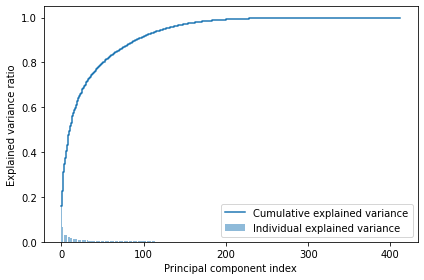

In [ ]:



pca = PCA(n_components=200)
pca.fit(X)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X)
X_train_std = sc.transform(X)
#
# Import eigh method for calculating eigenvalues and eigenvectirs
#
from numpy.linalg import eigh
#
# Determine covariance matrix
#
cov_matrix = np.cov(X_train_std, rowvar=False)
#
# Determine eigenvalues and eigenvectors
#
egnvalues, egnvectors = eigh(cov_matrix)
#
# Determine explained variance
#
total_egnvalues = sum(egnvalues)
var_exp = [(i/total_egnvalues) for i in sorted(egnvalues, reverse=True)]
#
# Plot the explained variance against cumulative explained variance
#
import matplotlib.pyplot as plt
cum_sum_exp = np.cumsum(var_exp)
plt.bar(range(0,len(var_exp)), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
X_train_s_pca=pca.transform(X)

In [ ]:
X_test_s_pca=pca.transform(imp.transform(X_test))

In [ ]:
clf=LogisticRegression(random_state=0).fit(X_train_s_pca,y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
y_pred=clf.predict(X_test_s_pca)

# Resutls of Statistical imputer with oversample with PCA


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.60      0.74     26587
           1       0.13      0.69      0.22      2260

    accuracy                           0.61     28847
   macro avg       0.54      0.65      0.48     28847
weighted avg       0.89      0.61      0.70     28847



So the best result is the Resutls of Statistical imputer with oversample with LDA
